<a href="https://colab.research.google.com/github/MoeinDSP/Simulating-social-media-platforms-with-Large-Language-Models/blob/main/SSMuLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
import json

from datetime import datetime
from itertools import combinations
from openai import OpenAI
from collections import defaultdict

In [14]:
models = {
    'Gemma-V3-1B': 'google/gemma-3-1b-it:free',
    'DeepSeek-V3-0324': 'deepseek/deepseek-chat-v3-0324:free'
}

base_urls = {
    'OpenRouter': 'https://openrouter.ai/api/v1',
}

clients_details = [
    {
        'base_url': base_urls['OpenRouter'],
        'api_key': "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"
    }, # zandiyeh1379
    {
        'base_url': base_urls['OpenRouter'],
        'api_key': "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"
    }, # oibf7950
    {
        'base_url': base_urls['OpenRouter'],
        'api_key': "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"
    },  # moein
]

clients = [
    OpenAI(
        base_url=client['base_url'],
        api_key=client['api_key']
    ) for client in clients_details
]

In [15]:
current_client_idx = 0
current_client = clients[current_client_idx]

def update_current_client():
  global current_client_idx, current_client
  current_client_idx = (current_client_idx + 1) % len(clients)
  current_client = clients[current_client_idx]

Social Network Creation

In [16]:
class Agent:
  def __init__(self, persona: dict):
    self.persona = persona

  def get_details(self):
    return ', '.join(f"{k}: {v}" for k, v in self.persona.items())

In [17]:
class SocialNetwork:
  def __init__(self, agents: list[Agent]):
    self.agents = agents
    self.network = self.__create_network()
    self.groups = []

  def __create_network(self):
    network = nx.Graph()
    network.add_nodes_from(range(len(self.agents)))
    return network

  def draw_network(self):
    nx.draw(self.network, with_labels=True)
    plt.show()

  def create_group(self, members: list[int], model: str):
    connections = list(combinations(members, 2))
    self.network.add_edges_from(connections)

    members = [self.agents[member] for member in members]
    group = Group(members, model)
    self.groups.append(group)

    return group

In [18]:
class Group:
  def __init__(self, members: list[Agent], model: str):
    self.members = members
    self.model = model
    self.chats = [] # [{'sender': <Agent>, 'message': <str>}, ...]

  def add_chat(self, member: Agent, message: str):
    chat = {'sender': member, 'message': message}
    self.chats.append(chat)

  def get_members_details(self, indices: list[int]):
    return '\n'.join(self.members[i].get_details() for i in indices)

  def get_chats_history(self, last_n: int|None = None):
    num_all_chats = len(self.chats)
    last_n = num_all_chats if (last_n is None) else min(last_n, num_all_chats)

    chats_history = ''
    for chat in self.chats[-last_n:]:
      chats_history += f"sender: {chat['sender'].persona['Name']}\n"
      chats_history += f"message: {chat['message']}\n\n"

    return chats_history

  def get_list_messages(self, member: Agent):
    return [chat['message'] for chat in self.chats if chat['sender'] == member]

  def get_dict_chats(self):
    dict_chats = defaultdict(lambda: {'messages': []})
    for chat in self.chats:
      dict_chats[chat['sender'].persona['Name']]['messages'].append(chat['message'])

    return dict(dict_chats)

  def send_message(self, sender_idx: int, prompt_start: str, len_chat_memory: int|None = None):
    sender_details = self.get_members_details([sender_idx])

    receivers_indices = [j for j in range(len(self.members)) if j != sender_idx]
    receivers_details = self.get_members_details(receivers_indices)

    prompt_intro = f"You are {sender_details}, engaging in a friendly conversation with:\n{receivers_details}\n\n"
    prompt_intro += f"Below is the chat history so far:\n\n{self.get_chats_history(len_chat_memory)}" #1. history of message

    def get_client_response():
      try:
        return current_client.chat.completions.create(
            model=self.model,
            messages=[
                {
                    'role': 'user',
                    'content': f"{prompt_intro}\n{prompt_start}"
                }
            ],
        )
      except:
        return None

    num_failed_tries = 0
    while True:
        response = get_client_response()
        if response is not None:
            break
        num_failed_tries += 1
        if num_failed_tries > len(clients):
            sys.exit('No response from any client')
        update_current_client()

    return response.choices[0].message.content.strip()

  def communicate(self, prompt_start: str, rounds: int, len_chat_memory: int|None = None):
    for _ in range(rounds):
      for sender_idx in range(len(self.members)):
        message = self.send_message(sender_idx, prompt_start, len_chat_memory)
        self.add_chat(self.members[sender_idx], message)
        print(self.get_chats_history(1))

Experiments

In [35]:
persona_keys = ['Name', 'Gender', 'Age', 'Economic Status', 'Occupation']
#2. change number of agents
#3. change the perosans
personas = [
  ['Kayla', 'Female', 'Teen', 'Working Class', 'TikTok Influencer'],
  ['Morgan', 'Nonbinary', 'Adult', 'Upper-Middle', 'Corporate Lawyer'],
  ['Frank', 'Male', 'Elderly', 'Poor', 'Uber Driver'], #4- socioeconomic diversity
  ['Karen', 'Female', 'Middle-Aged', 'Middle Class', 'Politician (Controversial)'],
  ['Leo', 'Male', 'Young Adult', 'Lower Class', 'Activist (Environmental)']
]

agents = [Agent(dict(zip(persona_keys, persona))) for persona in personas]

In [20]:
social_network = SocialNetwork(agents)

group_0_1_2 = social_network.create_group([0, 1, 2], models['DeepSeek-V3-0324']) #5. Group vs. 1-on-1 chats
#6. Initial source of message

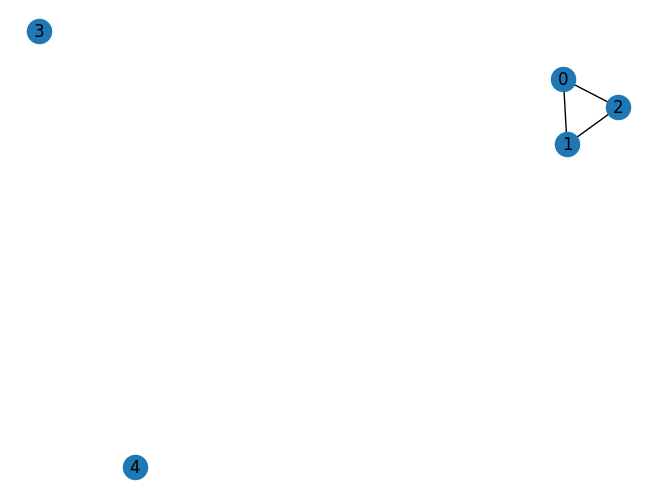

In [38]:
social_network.draw_network()

In [36]:
prompt_start = "The topic is work–life balance. Share how you handle stress from your job, and whether you believe in strict boundaries or letting work and personal life blend naturally."
# 7- sentiment tone of initial message,
# 8- Message type

In [37]:
group_0_1_2.communicate(prompt_start, 5) # 1. number of interactions per agent

sender: Kayla
message: **Kayla:** *"OMG, WORK-LIFE BALANCE?? As if my life isn’t just one big TikTok audition 24/7 😂 Honestly, stress hits different when your ‘office’ is your bedroom floor with ring-light acne—but I *try* to unplug by binge-watching trash TV with my cats. No sponsors, no edits, just me and Mr. Whiskers judging *Love Is Blind* like it’s our job. 🐱🍿 Morgan, how do you *not* burn out billing hours like it’s a competitive sport? And Frank, please tell me you’ve perfected the art of ‘clock out and vibes’ between rides!"* **(cat emoji, couch emoji)**  

**Morgan:** *"Bold of you to assume I *don’t* burn out, Kayla 😂 I’ve accepted that my ‘balance’ is a piña colada at 2 AM while drafting cease-and-desist letters. *But*—I do mute my work emails on weekends… unless it’s a ‘Karen with soap samples’ emergency. Frank, teach us your ways—you’ve gotta have *some* zen wisdom from driving through traffic and chaos all day."* **(tropical drink emoji, sweat emoji)**  

**Frank:** *"Oh 

TypeError: 'NoneType' object is not subscriptable

In [39]:
prompt_id = "work_life_balance"

In [40]:
# Define the full list of participant names
all_participants = [agent.persona["Name"] for agent in group_0_1_2.members]

# Structure the chat data with sender and recipients
structured_data = []
for chat in group_0_1_2.chats:
    sender_name = chat["sender"].persona["Name"]
    recipients = [name for name in all_participants if name != sender_name]
    structured_data.append({
        "sender": sender_name,
        "recipients": recipients,
        "message": chat["message"]
    })

# Save with filename based on prompt_id
filename = f"structured_chat_dataset_{prompt_id}.json"
with open(filename, "w", encoding="utf-8") as f:
    json.dump(structured_data, f, indent=2, ensure_ascii=False)
